In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


BATCH_SIZE = 128
EPOCHS = 100
IMG_SIZE = 224
LR = 3e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Download latest version
path = kagglehub.dataset_download("jutrera/stanford-car-dataset-by-classes-folder")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stanford-car-dataset-by-classes-folder


# ===================================
# 1. Data Exploartion
# ===================================

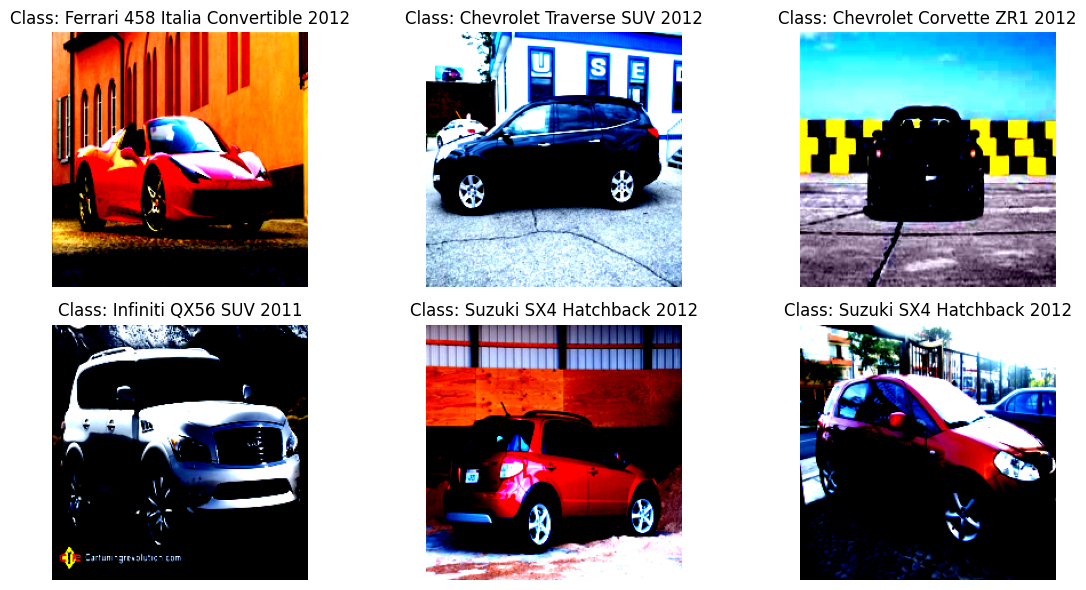

In [17]:

# Show random samples from training set
def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_samples(val_ds)

# ===================================
# 2. DATASET & TRANSFORMS
# ===================================

In [ ]:

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_ds = datasets.ImageFolder("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train", transform=train_tf)
val_ds = datasets.ImageFolder("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train", transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)
print(f"Classes: {num_classes}")



# ===================================
# 3. MODEL ARCHITECTURE (Custom SE-ResNet)
# ===================================

In [ ]:

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x)
        return x * w

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.se = SEBlock(out_channels)
        self.shortcut = (
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            ) if in_channels != out_channels or stride != 1 else nn.Identity()
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        out += self.shortcut(x)
        return torch.relu(out)

class CarResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.stage1 = nn.Sequential(
            ResidualBlock(64, 128, stride=1),
            ResidualBlock(128, 128)
        )
        self.stage2 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.stage3 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        self.stage4 = nn.Sequential(
            ResidualBlock(512, 1024, stride=2),
            ResidualBlock(1024, 1024)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = CarResNet(num_classes).to(DEVICE)
print(model)


# ===================================
# 4. TRAINING LOOP WITH TQDM
# ===================================

# ===================================
# 5. VISUALIZATION
# ===================================

Classes: 196
CarResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (se): SEBlock(
        (fc): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): R

Epoch [1/100] | Train Loss: 5.285 | Val Loss: 5.183 | Train Acc: 0.74% | Val Acc: 1.60%


Epoch [2/100] | Train Loss: 5.193 | Val Loss: 5.110 | Train Acc: 1.19% | Val Acc: 1.69%


Epoch [3/100] | Train Loss: 5.145 | Val Loss: 5.087 | Train Acc: 1.41% | Val Acc: 2.09%


Epoch [4/100] | Train Loss: 5.106 | Val Loss: 5.024 | Train Acc: 1.73% | Val Acc: 1.94%


Epoch [5/100] | Train Loss: 5.065 | Val Loss: 4.947 | Train Acc: 2.05% | Val Acc: 3.22%


Epoch [6/100] | Train Loss: 5.014 | Val Loss: 4.994 | Train Acc: 2.23% | Val Acc: 2.35%


Epoch [7/100] | Train Loss: 4.964 | Val Loss: 4.856 | Train Acc: 2.71% | Val Acc: 3.49%


Epoch [8/100] | Train Loss: 4.884 | Val Loss: 4.992 | Train Acc: 3.16% | Val Acc: 2.65%


Epoch [9/100] | Train Loss: 4.836 | Val Loss: 4.659 | Train Acc: 3.43% | Val Acc: 4.67%


Epoch [10/100] | Train Loss: 4.741 | Val Loss: 4.773 | Train Acc: 3.97% | Val Acc: 3.89%


Epoch [11/100] | Train Loss: 4.688 | Val Loss: 4.830 | Train Acc: 4.42% | Val Acc: 4.14%


Epoch [12/100] | Train Loss: 4.571 | Val Loss: 4.467 | Train Acc: 5.30% | Val Acc: 6.39%


Epoch [13/100] | Train Loss: 4.464 | Val Loss: 4.294 | Train Acc: 6.05% | Val Acc: 7.21%


Epoch [14/100] | Train Loss: 4.366 | Val Loss: 4.292 | Train Acc: 6.78% | Val Acc: 7.71%


Epoch [15/100] | Train Loss: 4.255 | Val Loss: 3.990 | Train Acc: 6.94% | Val Acc: 10.07%


Epoch [16/100] | Train Loss: 4.125 | Val Loss: 3.925 | Train Acc: 7.99% | Val Acc: 10.85%


Epoch [17/100] | Train Loss: 4.021 | Val Loss: 3.808 | Train Acc: 9.36% | Val Acc: 11.98%


Epoch [18/100] | Train Loss: 3.902 | Val Loss: 3.930 | Train Acc: 10.74% | Val Acc: 11.92%


Epoch [19/100] | Train Loss: 3.784 | Val Loss: 3.841 | Train Acc: 11.63% | Val Acc: 10.83%


Epoch [20/100] | Train Loss: 3.681 | Val Loss: 3.792 | Train Acc: 12.92% | Val Acc: 12.30%


Epoch [21/100] | Train Loss: 3.584 | Val Loss: 3.319 | Train Acc: 13.89% | Val Acc: 18.77%


Epoch [22/100] | Train Loss: 3.464 | Val Loss: 3.329 | Train Acc: 15.31% | Val Acc: 17.94%


Epoch [23/100] | Train Loss: 3.366 | Val Loss: 3.214 | Train Acc: 16.70% | Val Acc: 21.16%


Epoch [24/100] | Train Loss: 3.226 | Val Loss: 3.231 | Train Acc: 19.20% | Val Acc: 20.11%


Epoch [25/100] | Train Loss: 3.129 | Val Loss: 3.057 | Train Acc: 19.43% | Val Acc: 21.80%


Epoch [26/100] | Train Loss: 3.002 | Val Loss: 2.970 | Train Acc: 22.30% | Val Acc: 22.84%


Epoch [27/100] | Train Loss: 2.885 | Val Loss: 2.469 | Train Acc: 24.39% | Val Acc: 34.26%


Epoch [28/100] | Train Loss: 2.764 | Val Loss: 2.534 | Train Acc: 27.17% | Val Acc: 30.89%


Epoch [29/100] | Train Loss: 2.678 | Val Loss: 2.488 | Train Acc: 28.22% | Val Acc: 32.70%


Epoch [30/100] | Train Loss: 2.556 | Val Loss: 2.514 | Train Acc: 30.00% | Val Acc: 32.06%


Epoch [31/100] | Train Loss: 2.443 | Val Loss: 1.976 | Train Acc: 32.22% | Val Acc: 46.16%


Epoch [32/100] | Train Loss: 2.294 | Val Loss: 2.265 | Train Acc: 35.55% | Val Acc: 36.68%


Epoch [33/100] | Train Loss: 2.216 | Val Loss: 2.181 | Train Acc: 37.70% | Val Acc: 37.94%


Epoch [34/100] | Train Loss: 2.094 | Val Loss: 1.849 | Train Acc: 40.16% | Val Acc: 46.24%


Epoch [35/100] | Train Loss: 2.040 | Val Loss: 2.022 | Train Acc: 41.32% | Val Acc: 42.62%


Epoch [36/100] | Train Loss: 1.917 | Val Loss: 1.776 | Train Acc: 44.82% | Val Acc: 49.20%


Epoch [37/100] | Train Loss: 1.817 | Val Loss: 1.520 | Train Acc: 46.81% | Val Acc: 55.26%


Epoch [38/100] | Train Loss: 1.755 | Val Loss: 1.464 | Train Acc: 48.06% | Val Acc: 56.73%


Epoch [39/100] | Train Loss: 1.660 | Val Loss: 1.156 | Train Acc: 50.32% | Val Acc: 65.00%


Epoch [40/100] | Train Loss: 1.554 | Val Loss: 1.262 | Train Acc: 53.65% | Val Acc: 62.57%


Epoch [41/100] | Train Loss: 1.494 | Val Loss: 2.271 | Train Acc: 54.86% | Val Acc: 38.33%


Epoch [42/100] | Train Loss: 1.387 | Val Loss: 1.623 | Train Acc: 57.63% | Val Acc: 50.48%


Epoch [43/100] | Train Loss: 1.345 | Val Loss: 1.299 | Train Acc: 58.98% | Val Acc: 60.50%


Epoch [44/100] | Train Loss: 1.266 | Val Loss: 1.265 | Train Acc: 61.30% | Val Acc: 60.29%


Epoch [45/100] | Train Loss: 1.192 | Val Loss: 0.838 | Train Acc: 63.40% | Val Acc: 74.17%


Epoch [46/100] | Train Loss: 1.128 | Val Loss: 0.742 | Train Acc: 65.07% | Val Acc: 77.59%


Epoch [47/100] | Train Loss: 1.044 | Val Loss: 0.725 | Train Acc: 67.39% | Val Acc: 77.05%


Epoch [48/100] | Train Loss: 0.996 | Val Loss: 0.639 | Train Acc: 69.34% | Val Acc: 80.75%


Epoch [49/100] | Train Loss: 0.929 | Val Loss: 0.795 | Train Acc: 70.68% | Val Acc: 74.53%


Epoch [50/100] | Train Loss: 0.897 | Val Loss: 0.683 | Train Acc: 71.71% | Val Acc: 77.82%


Epoch [51/100] | Train Loss: 0.842 | Val Loss: 0.696 | Train Acc: 73.47% | Val Acc: 78.05%


Epoch [52/100] | Train Loss: 0.773 | Val Loss: 0.473 | Train Acc: 75.34% | Val Acc: 85.84%


Epoch [53/100] | Train Loss: 0.723 | Val Loss: 0.607 | Train Acc: 76.65% | Val Acc: 80.27%


Epoch [54/100] | Train Loss: 0.711 | Val Loss: 0.473 | Train Acc: 77.62% | Val Acc: 84.86%


Epoch [55/100] | Train Loss: 0.642 | Val Loss: 0.324 | Train Acc: 79.00% | Val Acc: 90.37%


Epoch [56/100] | Train Loss: 0.590 | Val Loss: 0.363 | Train Acc: 81.18% | Val Acc: 88.68%


Epoch [57/100] | Train Loss: 0.559 | Val Loss: 0.260 | Train Acc: 81.81% | Val Acc: 92.69%


Epoch [58/100] | Train Loss: 0.540 | Val Loss: 0.269 | Train Acc: 82.90% | Val Acc: 92.15%


Epoch [59/100] | Train Loss: 0.513 | Val Loss: 0.241 | Train Acc: 83.24% | Val Acc: 93.10%


Epoch [60/100] | Train Loss: 0.483 | Val Loss: 0.211 | Train Acc: 84.97% | Val Acc: 94.18%


Epoch [61/100] | Train Loss: 0.452 | Val Loss: 0.247 | Train Acc: 85.95% | Val Acc: 92.49%


Epoch [62/100] | Train Loss: 0.420 | Val Loss: 0.210 | Train Acc: 86.03% | Val Acc: 93.87%


Epoch [63/100] | Train Loss: 0.410 | Val Loss: 0.177 | Train Acc: 87.06% | Val Acc: 94.99%


Epoch [64/100] | Train Loss: 0.396 | Val Loss: 0.150 | Train Acc: 87.36% | Val Acc: 95.96%


Epoch [65/100] | Train Loss: 0.359 | Val Loss: 0.136 | Train Acc: 89.08% | Val Acc: 96.49%


Epoch [66/100] | Train Loss: 0.339 | Val Loss: 0.143 | Train Acc: 89.42% | Val Acc: 96.07%


Epoch [67/100] | Train Loss: 0.317 | Val Loss: 0.120 | Train Acc: 89.99% | Val Acc: 96.97%


Epoch [68/100] | Train Loss: 0.290 | Val Loss: 0.092 | Train Acc: 91.07% | Val Acc: 98.00%


Epoch [69/100] | Train Loss: 0.288 | Val Loss: 0.074 | Train Acc: 90.94% | Val Acc: 98.48%


Epoch [70/100] | Train Loss: 0.264 | Val Loss: 0.073 | Train Acc: 91.94% | Val Acc: 98.50%


Epoch [71/100] | Train Loss: 0.261 | Val Loss: 0.063 | Train Acc: 91.93% | Val Acc: 98.78%


Epoch [72/100] | Train Loss: 0.239 | Val Loss: 0.066 | Train Acc: 92.76% | Val Acc: 98.77%


Epoch [73/100] | Train Loss: 0.222 | Val Loss: 0.056 | Train Acc: 93.22% | Val Acc: 98.82%


Epoch [74/100] | Train Loss: 0.214 | Val Loss: 0.052 | Train Acc: 93.47% | Val Acc: 99.02%


Epoch [75/100] | Train Loss: 0.199 | Val Loss: 0.041 | Train Acc: 93.92% | Val Acc: 99.36%


Epoch [76/100] | Train Loss: 0.195 | Val Loss: 0.048 | Train Acc: 94.39% | Val Acc: 99.03%


Epoch [77/100] | Train Loss: 0.188 | Val Loss: 0.033 | Train Acc: 94.27% | Val Acc: 99.52%


Epoch [78/100] | Train Loss: 0.175 | Val Loss: 0.032 | Train Acc: 94.82% | Val Acc: 99.53%


Epoch [79/100] | Train Loss: 0.173 | Val Loss: 0.035 | Train Acc: 94.82% | Val Acc: 99.40%


Epoch [80/100] | Train Loss: 0.173 | Val Loss: 0.027 | Train Acc: 94.70% | Val Acc: 99.64%


Epoch [81/100] | Train Loss: 0.170 | Val Loss: 0.027 | Train Acc: 94.70% | Val Acc: 99.59%


Epoch [82/100] | Train Loss: 0.158 | Val Loss: 0.025 | Train Acc: 95.49% | Val Acc: 99.67%


Epoch [83/100] | Train Loss: 0.157 | Val Loss: 0.026 | Train Acc: 95.28% | Val Acc: 99.62%


Epoch [84/100] | Train Loss: 0.155 | Val Loss: 0.025 | Train Acc: 95.48% | Val Acc: 99.71%


Epoch [85/100] | Train Loss: 0.145 | Val Loss: 0.023 | Train Acc: 96.06% | Val Acc: 99.68%


Epoch [86/100] | Train Loss: 0.141 | Val Loss: 0.023 | Train Acc: 96.02% | Val Acc: 99.66%


Epoch [87/100] | Train Loss: 0.146 | Val Loss: 0.022 | Train Acc: 95.86% | Val Acc: 99.67%


Epoch [88/100] | Train Loss: 0.132 | Val Loss: 0.021 | Train Acc: 96.44% | Val Acc: 99.69%


Epoch [89/100] | Train Loss: 0.136 | Val Loss: 0.020 | Train Acc: 96.06% | Val Acc: 99.72%


Epoch [90/100] | Train Loss: 0.119 | Val Loss: 0.019 | Train Acc: 96.81% | Val Acc: 99.77%


Epoch [91/100] | Train Loss: 0.127 | Val Loss: 0.019 | Train Acc: 96.56% | Val Acc: 99.72%


Epoch [92/100] | Train Loss: 0.121 | Val Loss: 0.019 | Train Acc: 96.57% | Val Acc: 99.73%


Epoch [93/100] | Train Loss: 0.125 | Val Loss: 0.018 | Train Acc: 96.56% | Val Acc: 99.71%


Epoch [94/100] | Train Loss: 0.125 | Val Loss: 0.018 | Train Acc: 96.54% | Val Acc: 99.73%


Epoch [95/100] | Train Loss: 0.118 | Val Loss: 0.018 | Train Acc: 96.98% | Val Acc: 99.72%


Epoch [96/100] | Train Loss: 0.122 | Val Loss: 0.017 | Train Acc: 96.75% | Val Acc: 99.74%


Epoch [97/100] | Train Loss: 0.120 | Val Loss: 0.017 | Train Acc: 96.84% | Val Acc: 99.71%


Epoch [98/100] | Train Loss: 0.114 | Val Loss: 0.017 | Train Acc: 96.91% | Val Acc: 99.72%


Epoch [99/100] | Train Loss: 0.119 | Val Loss: 0.017 | Train Acc: 96.76% | Val Acc: 99.73%


Epoch [100/100] | Train Loss: 0.124 | Val Loss: 0.018 | Train Acc: 96.45% | Val Acc: 99.74%


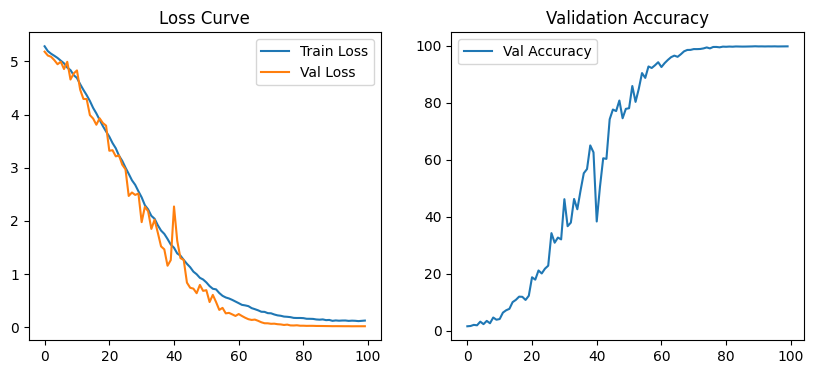

In [2]:




criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    train_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        train_bar.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_dl)
    train_acc = 100 * correct / total
    train_loss_hist.append(train_loss)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    val_bar = tqdm(val_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            val_bar.set_postfix(loss=loss.item())

    val_loss /= len(val_dl)
    val_acc = 100 * correct / total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_acc_hist, label='Val Accuracy')
plt.legend(); plt.title("Validation Accuracy")
plt.show()

torch.save(model.state_dict(), "best_car_model_tqdm.pth")



In [4]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,728
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
           Conv2d-11              [-1, 8, 1, 1]           1,032
             ReLU-12              [-1, 8, 1, 1]               0
           Conv2d-13            [-1, 128, 1, 1]           1,152
          Sigmoid-14            [-1, 12

# ==========================
# 4. DATA EXPLORATION
# ==========================

# =================================================
# 2. EVALUATE ON TEST SET
# =================================================
correct, total = 0, 0

Testing: 100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


✅ Test Accuracy: 99.74%


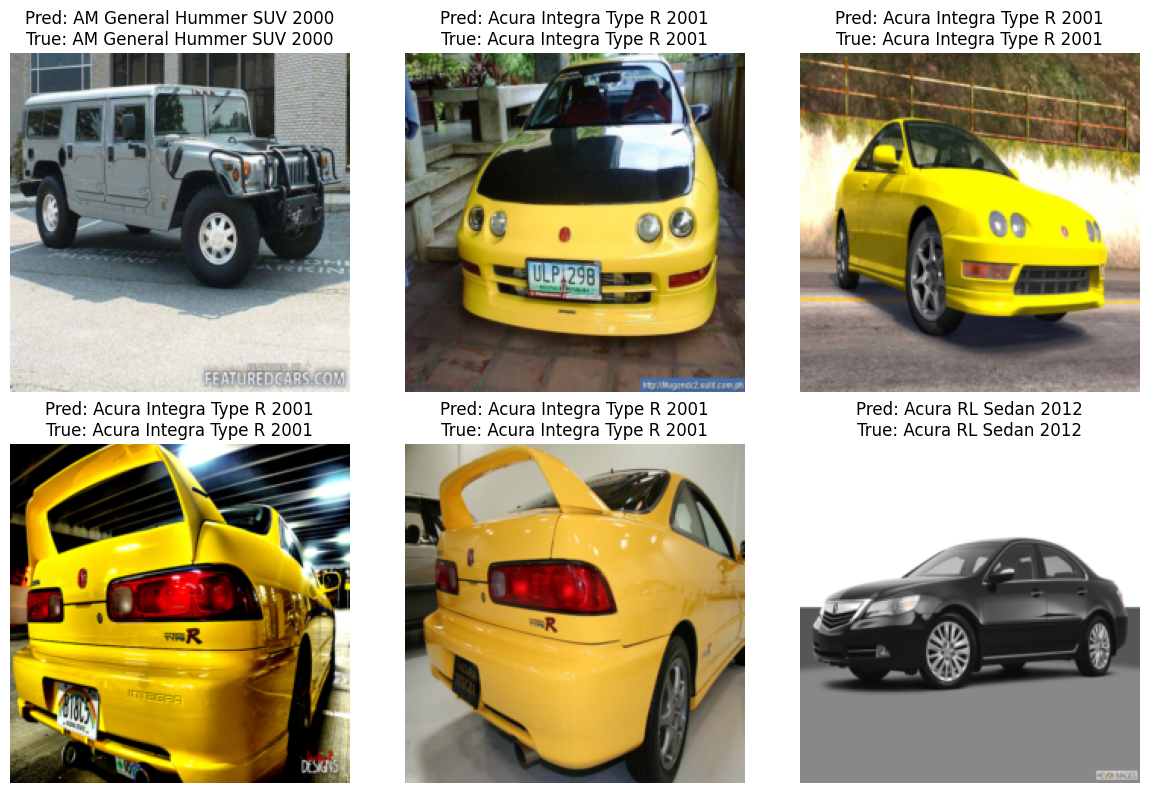

Misclassified samples: 21 / 8144


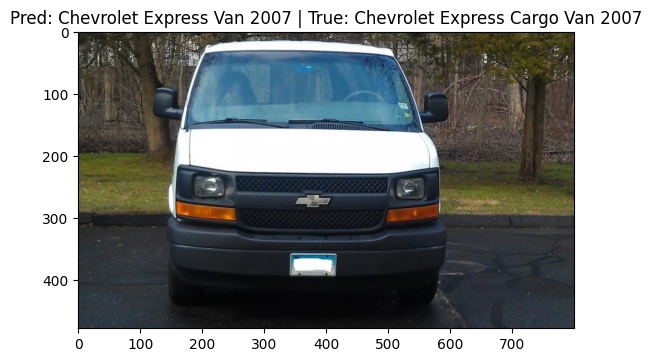

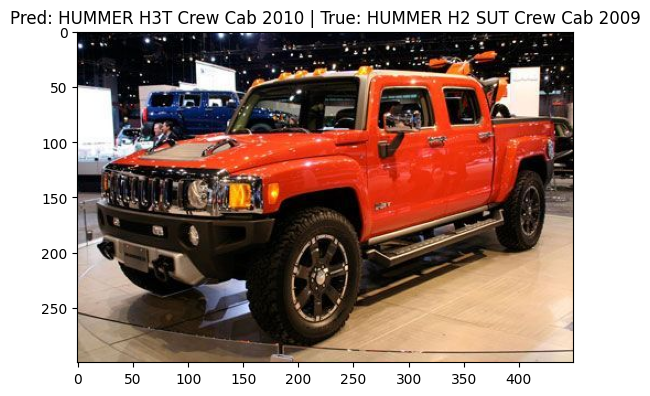

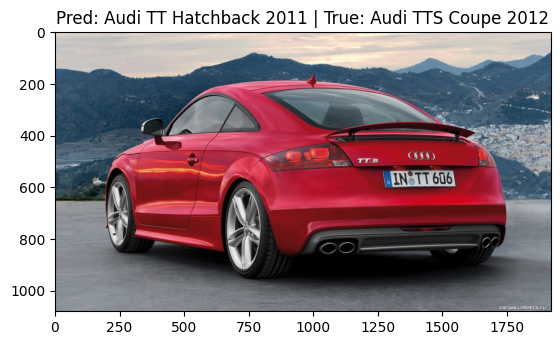

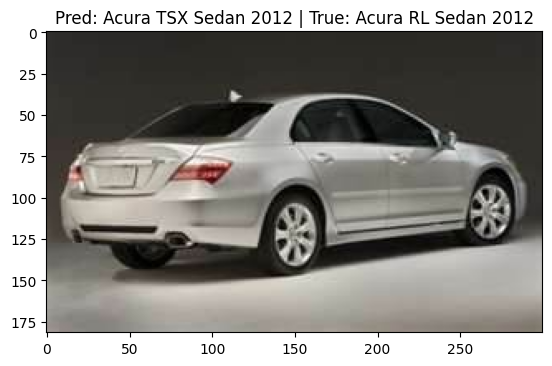

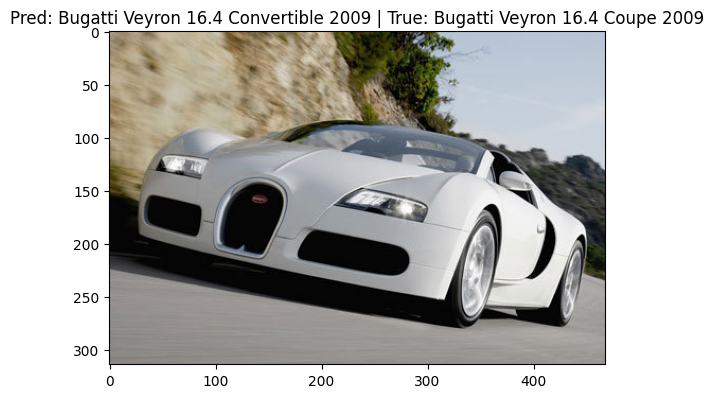

In [19]:
import random
import numpy as np
from PIL import Image


all_preds, all_labels = [], []

test_bar = tqdm(val_dl, desc="Testing", leave=True)
with torch.no_grad():
    for imgs, labels in test_bar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")

# =================================================
# 3. SHOW SAMPLE PREDICTIONS
# =================================================
import matplotlib.pyplot as plt

# Take random batch
dataiter = iter(val_dl)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 8))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(6):
    idx = random.randint(0, len(images) - 1)
    img = images[idx].cpu().permute(1, 2, 0).numpy()
    img = std * img + mean     # ← same operation but all NumPy
    img = np.clip(img, 0, 1)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {train_ds.classes[preds[idx]]}\nTrue: {train_ds.classes[labels[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# =================================================
# 4. OPTIONAL – MISCLASSIFIED EXAMPLES
# =================================================
mis_idx = [i for i in range(len(all_labels)) if all_preds[i] != all_labels[i]]
print(f"Misclassified samples: {len(mis_idx)} / {len(all_labels)}")

indices = random.sample(mis_idx, 5)
for i in indices:
    path, _ = val_ds.samples[i]
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Pred: {train_ds.classes[all_preds[i]]} | True: {train_ds.classes[all_labels[i]]}")
    plt.show()